In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
import numpy as np

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



In [105]:
# read manual_label.csv

df_gt = pd.read_csv('./data/manual_label.csv')
# read prediction.csv
df_pred_vanilla_gpt4 = pd.read_csv('./data/results/Vanilla-gpt4.csv')
df_pred_vanilla_gpt4o = pd.read_csv('./data/results/Vanilla-gpt4o.csv')
df_pred_vanilla_gpt4o_mini = pd.read_csv('./data/results/Vanilla-gpt4o-mini.csv')
df_pred_COT_gpt4 = pd.read_csv('./data/results/COT-gpt4.csv')
df_pred_COT_gpt4o = pd.read_csv('./data/results/COT-gpt4o.csv')
df_pred_COT_gpt4o_mini = pd.read_csv('./data/results/COT-gpt4o-mini.csv')
df_pred_few_shots_gpt4 = pd.read_csv('./data/results/few-shots-gpt4.csv')
df_pred_few_shots_gpt4o = pd.read_csv('./data/results/few-shots-gpt4o.csv')
df_pred_few_shots_gpt4o_mini = pd.read_csv('./data/results/few-shots-gpt4o-mini.csv')
df_pred_api_gpt4o = pd.read_csv('./data/results/API-gpt4o_xh.csv')
df_pred_api_gpt4o_mini = pd.read_csv('./data/results/API-gpt4o-mini_xh.csv')
df_pred_api_gpt4_turbo = pd.read_csv('./data/results/API-gpt-4-turbo_xh.csv')

In [106]:
COL='temperature'
df_kde=pd.read_csv(f'./data/anomalous_{COL}.csv')
df_kde['timestamp'] = df_kde['timestamp'].astype(int)
df_kde['timestamp'] = (df_kde['timestamp']- 1468800) // 30
df_kde['timestamp'] = df_kde['timestamp'].astype(int)
df_kde[f'{COL}_anomaly']=1

In [107]:
def merge_pred_and_gt(labeled_df, anomalous_pred,col_gt=f'anomaly_{COL}',col_pred=f'{COL}_anomaly'):
    pred=anomalous_pred[['nodeid','timestamp',col_pred]]
    y_true=labeled_df[['nodeid','timestamp','temperature','humidity','voltage',col_gt]]
    merged=pd.merge(y_true,pred, on=['nodeid','timestamp'], how='outer')
    merged[[col_pred]]=merged[[col_pred]].fillna(0)
    # convert int8 to boolean
    merged[col_gt]=merged[col_gt].astype(int)
    merged[col_pred]=merged[col_pred].astype(int)
    # use only the first 2 hours for a fair comparison
    one_hour=120
    merged=merged[np.logical_and(merged['timestamp']>one_hour*10,merged['timestamp']<one_hour*15)]
    return merged

In [108]:
merged_kde=merge_pred_and_gt(df_gt,df_kde)
# merged_gpt4_api_mini=merge_pred_and_gt(df_gt,df_pred_api_gpt4o_mini)
y_gt=merged_kde['anomaly_temperature']
y_gpt4_api_mini=merged_kde['temperature_anomaly']
print("Confusion matrix for temperature:")
model_idx=10
print(confusion_matrix(y_gt,y_gpt4_api_mini ))
# print("Classification report for temperature:")
print(classification_report(y_gt, y_gpt4_api_mini))

f1 = f1_score(y_gt, y_gpt4_api_mini,average='binary')
print(f'F1 score: {f1:.2f}')

Confusion matrix for temperature:
[[32289     0]
 [   57     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32289
           1       0.00      0.00      0.00        57

    accuracy                           1.00     32346
   macro avg       0.50      0.50      0.50     32346
weighted avg       1.00      1.00      1.00     32346

F1 score: 0.00


/home/sijic/anaconda3/envs/mts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sijic/anaconda3/envs/mts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sijic/anaconda3/envs/mts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [109]:
merged_gpt4=merge_pred_and_gt(df_gt,df_pred_vanilla_gpt4)
merged_gpt4o=merge_pred_and_gt(df_gt,df_pred_vanilla_gpt4o)
merged_gpt4o_mini=merge_pred_and_gt(df_gt,df_pred_vanilla_gpt4o_mini)
merged_gpt4_COT=merge_pred_and_gt(df_gt,df_pred_COT_gpt4)
merged_gpt4o_COT=merge_pred_and_gt(df_gt,df_pred_COT_gpt4o)
merged_gpt4o_mini_COT=merge_pred_and_gt(df_gt,df_pred_COT_gpt4o_mini)
merged_gpt4_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4)
merged_gpt4o_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4o)
merged_gpt4o_mini_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4o_mini)
merged_gpt4_api=merge_pred_and_gt(df_gt,df_pred_api_gpt4o)
merged_gpt4_api_mini=merge_pred_and_gt(df_gt,df_pred_api_gpt4o_mini)
merged_gpt4_api_turbo=merge_pred_and_gt(df_gt,df_pred_api_gpt4_turbo)
merged_kde=merge_pred_and_gt(df_gt,df_kde)

y_gt=merged_gpt4[f'anomaly_{COL}']
y_gpt4=merged_gpt4[f'{COL}_anomaly']
y_gpt4o=merged_gpt4o[f'{COL}_anomaly']
y_gpt4o_mini=merged_gpt4o_mini[f'{COL}_anomaly']
y_gpt4_COT=merged_gpt4_COT[f'{COL}_anomaly']
y_gpt4o_COT=merged_gpt4o_COT[f'{COL}_anomaly']
y_gpt4o_mini_COT=merged_gpt4o_mini_COT[f'{COL}_anomaly']
y_gpt4_few_shots=merged_gpt4_few_shots[f'{COL}_anomaly']
y_gpt4o_few_shots=merged_gpt4o_few_shots[f'{COL}_anomaly']
y_gpt4o_mini_few_shots=merged_gpt4o_mini_few_shots[f'{COL}_anomaly']
y_gpt4_api=merged_gpt4_api[f'{COL}_anomaly']
y_gpt4_api_mini=merged_gpt4_api_mini[f'{COL}_anomaly']
y_gpt4_api_turbo=merged_gpt4_api_turbo[f'{COL}_anomaly']
y_kde=merged_kde[f'{COL}_anomaly'] 

In [110]:
line_styles=['-',':','-.']
prediction_list=[y_gpt4,y_gpt4o,y_gpt4o_mini,y_gpt4_COT,y_gpt4o_COT,y_gpt4o_mini_COT,y_gpt4_few_shots,y_gpt4o_few_shots,y_gpt4o_mini_few_shots,y_gpt4_api,y_gpt4_api_mini,y_gpt4_api_turbo,y_kde]
prediction_labels=['Vanilla-gpt4','Vanilla-gpt4o','Vanilla-gpt4o-mini','COT-gpt4','COT-gpt4o','COT-gpt4o-mini','few-shots-gpt4','few-shots-gpt4o','few-shots-gpt4o-mini','API-gpt4o','API-gpt4o-mini','API-gpt4-turbo','KDE']

In [117]:
line_styles=['-','-','-',':',':',':']
prediction_list=[y_gpt4_few_shots,y_gpt4o_few_shots,y_gpt4o_mini_few_shots,y_gpt4_api,y_gpt4_api_mini,y_gpt4_api_turbo]
prediction_labels=['few-shots-gpt4','few-shots-gpt4o','few-shots-gpt4o-mini','API-gpt4o','API-gpt4o-mini','API-gpt4-turbo']

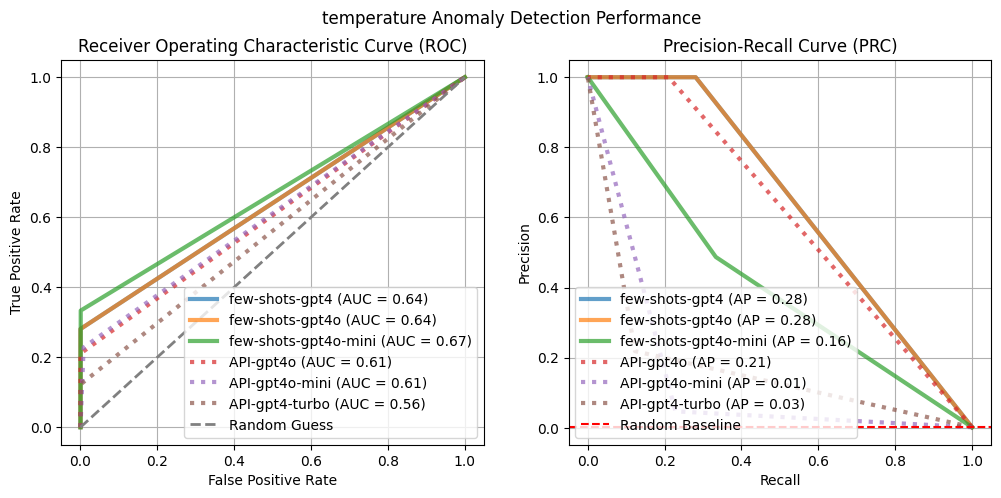

In [118]:
# Plot ROC Curve
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()
for i,label in enumerate(prediction_labels):
    # Compute False Positive Rate, True Positive Rate, and Thresholds
    fpr, tpr, thresholds = roc_curve(y_gt, prediction_list[i])
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, lw=3, label=f'{label} (AUC = %0.2f)' % roc_auc, alpha=0.7,linestyle=line_styles[i])


axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic Curve (ROC)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot Precision-Recall curve
# Compute Precision-Recall curve and Average Precision (AP)
for i,label in enumerate(prediction_labels):
    average_precision = average_precision_score(y_gt, prediction_list[i])
    precision, recall, thresholds = precision_recall_curve(y_gt, prediction_list[i])    
    axs[1].plot(recall, precision,  lw=3, label=f'{label} (AP = {average_precision:.2f})', alpha=0.7,linestyle=line_styles[i])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve (PRC)')

axs[1].grid(True)

# Add Random Model Line (baseline)
axs[1].axhline(y=sum(y_gt) / len(y_gt), color='red', linestyle='--', label='Random Baseline')
axs[1].legend(loc='lower left')
fig.suptitle(f'{COL} Anomaly Detection Performance')
plt.show()

In [57]:
# confusion matrix

print("Confusion matrix for temperature:")
model_idx=1
print(confusion_matrix(y_gt, prediction_list[model_idx]))
# print("Classification report for temperature:")
print(classification_report(y_gt, prediction_list[model_idx]))

f1 = f1_score(y_gt, prediction_list[model_idx],average='binary')
print(f'F1 score: {f1:.2f}')




Confusion matrix for temperature:
[[922021      0]
 [  3260   7839]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    922021
           1       1.00      0.71      0.83     11099

    accuracy                           1.00    933120
   macro avg       1.00      0.85      0.91    933120
weighted avg       1.00      1.00      1.00    933120

F1 score: 0.83


In [65]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score
for i,label in enumerate(prediction_labels):
    f1 = average_precision_score(y_gt, prediction_list[i])
    print(f'{f1:.2f},')

0.83,
0.26,
0.71,
0.83,
0.71,
0.71,
0.69,
0.28,
0.83,
0.01,
0.01,
0.01,
0.10,


In [98]:
merged_kde

,nodeid,timestamp,temperature,humidity,voltage,anomaly_temperature,temperature_anomaly
0,1,0,NaN,NaN,NaN,0,0
1,1,1,NaN,NaN,NaN,0,0
2,1,2,NaN,NaN,NaN,0,0
3,1,3,NaN,NaN,NaN,0,0
4,1,4,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...
933115,54,17275,NaN,NaN,NaN,0,0
933116,54,17276,NaN,NaN,NaN,0,0
933117,54,17277,NaN,NaN,NaN,0,0
933118,54,17278,NaN,NaN,NaN,0,0


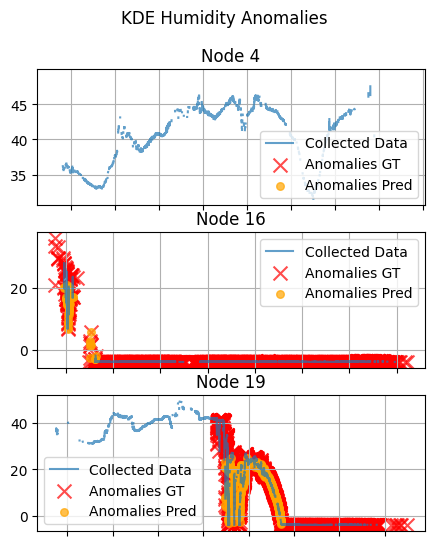

In [104]:
# plot anomalies for node_ids=[1,2,3,4] in a 2x2 grid
def plot_channel_with_anomalies(merged_gpt4, node_ids,col,anomaly_column_gt='anomaly_temperature',anomaly_column_pred='temperature_anomaly',title='Temperature Anomalies'):
    fig, axs = plt.subplots(3, 1, figsize=(5, 6))
    # ravel() converts a 2D array to a contiguous flattened array
    axs = axs.ravel()
    for i, node_id in enumerate(node_ids):
        node_data = merged_gpt4[merged_gpt4['nodeid'] == node_id]
        axs[i].plot(node_data['timestamp'], node_data[col], label='Collected Data', alpha=0.7)
        anomalies_gt = node_data[node_data[anomaly_column_gt] == 1]
        axs[i].scatter(anomalies_gt['timestamp'], anomalies_gt[col], color='red', label='Anomalies GT',alpha=0.7,s=100,marker='x')
        anomalies_pred = node_data[node_data[anomaly_column_pred] == 1]
        axs[i].scatter(anomalies_pred['timestamp'], anomalies_pred[col], color='orange', label='Anomalies Pred',alpha=0.7,s=30,marker='o')
        axs[i].set_title(f'Node {node_id}')
        axs[i].set_xticklabels([]) # not show x-axis labels
        axs[i].legend()
        axs[i].grid(True)
    # fig.tight_layout()
    fig.suptitle(title)

# merged_gpt4_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4, col_gt='anomaly_voltage',col_pred='voltage_anomaly')
# merged_gpt4o_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4o, col_gt='anomaly_voltage',col_pred='voltage_anomaly')
# merged_gpt4o_mini_few_shots=merge_pred_and_gt(df_gt,df_pred_few_shots_gpt4o_mini, col_gt='anomaly_voltage',col_pred='voltage_anomaly')
   
plot_channel_with_anomalies(merged_kde, [4,16,19], 'humidity', title='KDE Humidity Anomalies',
                            anomaly_column_gt='anomaly_humidity',anomaly_column_pred='humidity_anomaly')


In [312]:
merged_gpt4o_mini_few_shots

,nodeid,timestamp,temperature,humidity,voltage,anomaly_temperature,temperature_anomaly
0,1,0,NaN,NaN,NaN,0,0
1,1,1,NaN,NaN,NaN,0,0
2,1,2,NaN,NaN,NaN,0,0
3,1,3,NaN,NaN,NaN,0,0
4,1,4,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...
933115,54,17275,NaN,NaN,NaN,0,0
933116,54,17276,NaN,NaN,NaN,0,0
933117,54,17277,NaN,NaN,NaN,0,0
933118,54,17278,NaN,NaN,NaN,0,0
